### Homework 2: Twitter Mining

• Choose a popular Twitter account (≥ 10, 000 followers).

• Build the friendship graph for that account’s followers.

• Choose a method of community detection and apply it to that graph.

• Produce a visual display of your graph such that nodes belonging to different communities are differently colored.

In [1]:
import json
import pandas as pd
from twitter import *
from numpy import random

Replace twitter access token and other infomartion in associated auth_dict file

In [2]:
# Loading my authentication tokens
with open('auth_dict','r') as f:
    twtr_auth = json.load(f)

t = Twitter(auth=OAuth(twtr_auth['token'], twtr_auth['token_secret'], 
            twtr_auth['consumer_key'], twtr_auth['consumer_secret']))

In [3]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [4]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


In [5]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
        "Must have screen_names or user_ids, but not both"
    items_to_info = {}
    items = screen_names or user_ids
    sorted_by_follow_count = []
    while len(items) > 0:
        # Process 100 items at a time per the API specifications for /users/lookup.
        # See https://dev.twitter.com/docs/api/1.1/get/users/lookup for details.
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, user_id=items_str)
        for user_info in response:
            if screen_names:
                items_to_info[user_info['followers_count']] = user_info['screen_name']
            else: # user_ids
                items_to_info[user_info['followers_count']] = user_info['id']
        #print("RESPONCE", response)
        #print("DISCTIONAY", items_to_info)
    for key in sorted(items_to_info, reverse=True):
        sorted_by_follow_count.append(items_to_info[key])
    return sorted_by_follow_count[:5]

In [6]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['ID','ReciprocalFriend'])
df.to_csv('ReciprocalFriend.csv', index=False)

# Our function
def save_followers(fid, reciprocal_friend):
    data_frame_rf = [[str(fid), str(i)] for i in reciprocal_friend]
    #print(data_frame_rf)
    df = pd.DataFrame(data_frame_rf, columns=['ID','ReciprocalFriend'])
    with open('ReciprocalFriend.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

### Apply Breath First Search to generate friendship graph
Each time we are selecting 100 reciprocal friends and finding top 5 friends with highest follower count.  These 5 reciprocal friends will be used for next level of Breadth-First search.

In [7]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=seed_id,
                                 friends_limit=limit, followers_limit=limit)
    rp_friend = list(set(friends_ids) & set(followers_ids))
    top_five = get_user_profile(t, user_ids=rp_friend[:100])
    next_queue = top_five
    # Store a seed_id => _follower_ids mapping in MongoDB
    
    save_followers(seed_id, next_queue)
    
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth:
        print("Number of ", d,"- Distance node", len(next_queue))
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
            friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=fid,
                                friends_limit=limit, followers_limit=limit)
            # Store an ID with a string recording
            # IDs of followers of the user with ID "fid"
            rp_friend = list(set(friends_ids) & set(followers_ids))
            if (len(rp_friend) == 0):
                continue
            top_five = get_user_profile(t, user_ids=rp_friend[-100:])
            save_followers(str(fid), top_five)
            # Extending the list
            next_queue += top_five

In [8]:
screen_name = 'timoreilly'
crawl_followers(t, screen_name, depth=4, limit=5000)

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 1840 total friends ids for 2384071
Fetched 5000 total followers ids for 2384071
Number of  1 - Distance node 4
Fetched 1997 total friends ids for 13293162
Fetched 5000 total followers ids for 13293162
Fetched 1740 total friends ids for 2493137191
Fetched 5000 total followers ids for 2493137191
Fetched 674 total friends ids for 138818744
Fetched 5000 total followers ids for 138818744
Fetched 1823 total friends ids for 15813127
Fetched 5000 total followers ids for 15813127
Number of  2 - Distance node 20
Fetched 1840 total friends ids for 2384071
Fetched 5000 total followers ids for 2384071
Fetched 621 total friends ids for 36072985
Fetched 5000 total followers ids for 36072985
Fetched 1265 total friends ids for 3475
Fetched 5000 total followers ids for 3475
Fetched 1214 total friends ids for 17595439
Fetched 5000 total followers ids for 17595439
Fetched 3432 total friends ids for 252531143
Fetched 5000 total followers ids for 252531143
Fetched 5000 total friends ids for 94073646

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 1840 total friends ids for 2384071
Fetched 5000 total followers ids for 2384071
Fetched 5000 total friends ids for 153966123
Fetched 5000 total followers ids for 153966123
Fetched 808 total friends ids for 41602160
Fetched 5000 total followers ids for 41602160
Fetched 4395 total friends ids for 14539425
Fetched 5000 total followers ids for 14539425
Fetched 5000 total friends ids for 22239212
Fetched 5000 total followers ids for 22239212
Fetched 2851 total friends ids for 16129920
Fetched 5000 total followers ids for 16129920
Fetched 5000 total friends ids for 2922268330
Fetched 5000 total followers ids for 2922268330
Fetched 5000 total friends ids for 2466899838
Fetched 5000 total followers ids for 2466899838
Fetched 5000 total friends ids for 22756947
Fetched 5000 total followers ids for 22756947
Fetched 5000 total friends ids for 19050461
Fetched 5000 total followers ids for 19050461
Number of  3 - Distance node 84
Fetched 1997 total friends ids for 13293162
Fetched 5000 tota

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 138 total friends ids for 271294362
Fetched 216 total followers ids for 271294362
Fetched 0 total friends ids for 164351758
Fetched 0 total followers ids for 164351758
Fetched 273 total friends ids for 1605
Fetched 5000 total followers ids for 1605
Fetched 539 total friends ids for 17781673
Fetched 5000 total followers ids for 17781673
Fetched 4309 total friends ids for 9532402
Fetched 5000 total followers ids for 9532402
Fetched 500 total friends ids for 1282121312
Fetched 5000 total followers ids for 1282121312
Fetched 343 total friends ids for 18269449
Fetched 5000 total followers ids for 18269449
Fetched 577 total friends ids for 20263710
Fetched 5000 total followers ids for 20263710
Fetched 3953 total friends ids for 14031032
Fetched 5000 total followers ids for 14031032
Fetched 5000 total friends ids for 38445467
Fetched 5000 total followers ids for 38445467
Fetched 3528 total friends ids for 481867656
Fetched 5000 total followers ids for 481867656
Fetched 2584 total frie

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 1796 total friends ids for 14177942
Fetched 5000 total followers ids for 14177942
Fetched 5000 total friends ids for 15469000
Fetched 5000 total followers ids for 15469000
Fetched 5000 total friends ids for 583245674
Fetched 5000 total followers ids for 583245674
Fetched 5000 total friends ids for 42417984
Fetched 5000 total followers ids for 42417984
Fetched 5000 total friends ids for 22986573
Fetched 5000 total followers ids for 22986573
Fetched 5000 total friends ids for 42819565
Fetched 5000 total followers ids for 42819565
Fetched 5000 total friends ids for 2310938544
Fetched 5000 total followers ids for 2310938544
Fetched 5000 total friends ids for 5768872
Fetched 5000 total followers ids for 5768872
Fetched 5000 total friends ids for 179398386
Fetched 5000 total followers ids for 179398386
Fetched 522 total friends ids for 14051043
Fetched 5000 total followers ids for 14051043
Fetched 1282 total friends ids for 21207000
Fetched 5000 total followers ids for 21207000
Fetch

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 5000 total friends ids for 3187359674
Fetched 5000 total followers ids for 3187359674
Fetched 5000 total friends ids for 719666283336318976
Fetched 5000 total followers ids for 719666283336318976
Fetched 5000 total friends ids for 22986573
Fetched 5000 total followers ids for 22986573
Fetched 5000 total friends ids for 2750513041
Fetched 5000 total followers ids for 2750513041
Fetched 5000 total friends ids for 26304307
Fetched 5000 total followers ids for 26304307
Fetched 5000 total friends ids for 241278819
Fetched 5000 total followers ids for 241278819
Fetched 5000 total friends ids for 15466386
Fetched 5000 total followers ids for 15466386
Fetched 5000 total friends ids for 190906140
Fetched 5000 total followers ids for 190906140
Fetched 5000 total friends ids for 525713285
Fetched 5000 total followers ids for 525713285
Fetched 5000 total friends ids for 44171091
Fetched 5000 total followers ids for 44171091
Fetched 5000 total friends ids for 1419370418
Fetched 5000 total f

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 1823 total friends ids for 15813127
Fetched 5000 total followers ids for 15813127
Fetched 5000 total friends ids for 404102292
Fetched 5000 total followers ids for 404102292
Fetched 306 total friends ids for 779379510055763968
Fetched 5000 total followers ids for 779379510055763968
Fetched 614 total friends ids for 72559384
Fetched 5000 total followers ids for 72559384
Fetched 454 total friends ids for 706157000
Fetched 5000 total followers ids for 706157000
Fetched 578 total friends ids for 576256688
Fetched 5000 total followers ids for 576256688
Fetched 95 total friends ids for 183735745
Fetched 5000 total followers ids for 183735745
Fetched 514 total friends ids for 15677036
Fetched 5000 total followers ids for 15677036
Fetched 5000 total friends ids for 606412878
Fetched 5000 total followers ids for 606412878
Fetched 4636 total friends ids for 140883357
Fetched 5000 total followers ids for 140883357
Fetched 3209 total friends ids for 19665271
Fetched 5000 total followers id

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 5000 total friends ids for 2205388728
Fetched 5000 total followers ids for 2205388728
Fetched 5000 total friends ids for 106790805
Fetched 5000 total followers ids for 106790805
Fetched 346 total friends ids for 210957932
Fetched 5000 total followers ids for 210957932
Fetched 160 total friends ids for 3724175959
Fetched 2465 total followers ids for 3724175959
Fetched 5000 total friends ids for 1262776610
Fetched 5000 total followers ids for 1262776610
Fetched 221 total friends ids for 63839488
Fetched 5000 total followers ids for 63839488
Fetched 5000 total friends ids for 25387735
Fetched 5000 total followers ids for 25387735
Fetched 3105 total friends ids for 18533219
Fetched 5000 total followers ids for 18533219
Fetched 4479 total friends ids for 343438129
Fetched 5000 total followers ids for 343438129
Fetched 819 total friends ids for 308235132
Fetched 5000 total followers ids for 308235132
Fetched 2040 total friends ids for 22986148
Fetched 5000 total followers ids for 229

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 5000 total friends ids for 167781199
Fetched 5000 total followers ids for 167781199
Fetched 5000 total friends ids for 1262776610
Fetched 5000 total followers ids for 1262776610
Fetched 5000 total friends ids for 17850785
Fetched 5000 total followers ids for 17850785
Fetched 5000 total friends ids for 16126957
Fetched 5000 total followers ids for 16126957


### Read graph stored in a file from the earlier step and generate networkx graph.

In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [10]:
# Create Graph from file
df = pd.read_csv("ReciprocalFriend.csv")
x_point = list(df[df.columns[0]].values)
y_point = list(df[df.columns[1]].values)
edges_list = []
for i in range(len(x_point)):
    edges_list.append((x_point[i], y_point[i]))
node_list = set(x_point+y_point)
RG = nx.Graph()
RG.add_nodes_from(node_list)
RG.add_edges_from(edges_list)

In [11]:
# Display some graph information such as number of nodes and edges
print ("Number of Nodes :", RG.number_of_nodes())
print ("Numebr of edges :", RG.number_of_edges())

Number of Nodes : 384
Numebr of edges : 405


### Apply Spectral clustering on the graph to detect communities 

In [12]:
# find Laplacian matrix
A = nx.adjacency_matrix(RG)
D = np.diag(list(dict(nx.degree(RG)).values()))
L = D - A

In [13]:
# find required eigen value and eigen vector
lmbds,vctrs = np.linalg.eig(L)
indx = [i for i in range(len(lmbds)) if lmbds[i] > .01 and lmbds[i] < .03]
RG_mbd = vctrs[:,indx]
print ("We will devide our Graph in", len(indx), "communities")

We will devide our Graph in 3 communities


In [14]:
# Apply k-means
est = KMeans(n_clusters=len(indx))
est.fit(RG_mbd)

# Labels will give us community number for each node
# we will use same community number as color value for each node
labels = est.labels_

C:\Users\Bhushan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


### Display graph with the different color for each detected community

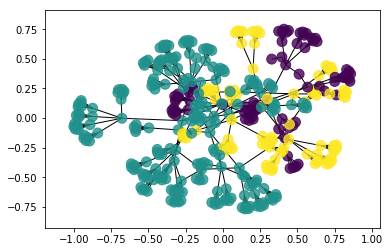

In [15]:
# Display Graph with different colors for each community
pos = nx.spring_layout(RG)
nx.draw_networkx_nodes(RG,pos,
                       nodelist=node_list,
                       node_color=labels,
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(RG,pos)
plt.show()